# Knowledge Distillation

**Based on other notebooks that use distillation [1](https://colab.research.google.com/github/sayakpaul/Knowledge-Distillation-in-Keras/blob/master/Distillation_with_Transfer_Learning.ipynb#scrollTo=b1jE623hh781), [2](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/knowledge_distillation.ipynb), [3](https://colab.research.google.com/drive/1-yHSQTljXyca2aSFhpM2y4n9B4M-KWso#scrollTo=3JApQdNz19bT), [4](https://koushik-nov01.medium.com/knowledge-distillation-with-pytorch-40febcf77440) for educational purposes**

Modern state-of-the-art neural network architectures are HUGE.

Unfortunately, more is sometimes not better when it comes to the number of parameters. Sure, more parameters seem to mean better results, but also massive computational costs.

However, deploying much smaller models can also present a significant challenge for machine learning engineers. In practice, small and fast models are much better than massive ones.

Because of this, researchers and engineers have put significant energy into compressing models.

To optimize these costs by compressing the models, three main methods have emerged:

*   Weight pruning
*   Quantization
*   knowledge distillation


Today we will focus on Knowledge Distillation. Knowledge Distillation is a procedure for model compression, in which a small (student) model is trained to match a large pre-trained (teacher) model.

Knowledge is transferred from the teacher model to the student by minimizing a loss function, aimed at matching the teacher outputs as well as ground-truth labels.

**Reference:**

- [Hinton et al. (2015)](https://arxiv.org/abs/1503.02531)

#Setup

In [ ]:
!pip install torchinfo

In [ ]:
# Necessary imports
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm import tqdm
from timeit import default_timer as timer

# For reproducibility
torch.manual_seed(0)
torch.backends.cudnn.benchmark = True

Define hyerparameters, and remember to set the runtime type accelerator as GPU.

In [ ]:
hparams = {
    'batch_size':32,
    'num_epochs':3,
    'num_classes':10,
    'learning_rate':1e-4,
    'learning_rate_dist': 5e-3,
    'log_interval':2000,
}
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
assert(hparams['device']=='cuda')

# Define MNIST dataset and dataloaders

In [ ]:
train_dataset = torchvision.datasets.MNIST(
    root="dataset/",
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="dataset/",
    train=False,
    transform=transforms.ToTensor(),
    download=True
)
# Create train and test dataloaders
train_loader = DataLoader(dataset=train_dataset, batch_size=hparams['batch_size'], shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=hparams['batch_size'], shuffle=False)

# Define the Teacher Model

In [ ]:
class TeacherModel(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(TeacherModel, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=64,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=64,
            out_channels=256,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.fc1 = nn.Linear(256 * 7 * 7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

## Exercise 1: Declare the teacher model, and list the number of parameters.

In [ ]:
# TODO: Declare the teacher model
teacher_model = TeacherModel()
# TODO: List its parameters, given an input of [bs, nchannels, width, depth], using the summary function from torchinfo
summary(teacher_model, (hparams['batch_size'],1,28,28))


Layer (type:depth-idx)                   Output Shape              Param #
TeacherModel                             --                        --
├─Conv2d: 1-1                            [32, 64, 28, 28]          640
├─MaxPool2d: 1-2                         [32, 64, 14, 14]          --
├─Conv2d: 1-3                            [32, 256, 14, 14]         147,712
├─MaxPool2d: 1-4                         [32, 256, 7, 7]           --
├─Linear: 1-5                            [32, 10]                  125,450
Total params: 273,802
Trainable params: 273,802
Non-trainable params: 0
Total mult-adds (M): 946.52
Input size (MB): 0.10
Forward/backward pass size (MB): 25.69
Params size (MB): 1.10
Estimated Total Size (MB): 26.89

# Define the student model.

In [ ]:
class StudentModel(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=8,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv2 = nn.Conv2d(
            in_channels=8,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.fc1 = nn.Linear(16 * 7 * 7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

## Exercise 2: Declare the student model, and list the number of parameters.

In [ ]:
# TODO: Declare the teacher model
student_model = StudentModel()
summary(student_model, (hparams['batch_size'],1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
StudentModel                             --                        --
├─Conv2d: 1-1                            [32, 8, 28, 28]           80
├─MaxPool2d: 1-2                         [32, 8, 14, 14]           --
├─Conv2d: 1-3                            [32, 16, 14, 14]          1,168
├─MaxPool2d: 1-4                         [32, 16, 7, 7]            --
├─Linear: 1-5                            [32, 10]                  7,850
Total params: 9,098
Trainable params: 9,098
Non-trainable params: 0
Total mult-adds (M): 9.58
Input size (MB): 0.10
Forward/backward pass size (MB): 2.41
Params size (MB): 0.04
Estimated Total Size (MB): 2.55

Let's define a helper function that computes the accuracy and the number of correct predictions.

In [ ]:
def check_accuracy(loader, model, device):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)


    model.train()
    return (num_correct/num_samples).item()

def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

Let's define a basic training pipeline for any network.

#Exercise 3: define the basic training pipeline

In [ ]:
device = hparams['device']
def train_model(model, criterion, optimizer, train_loader, epochs):
    for epoch in range(epochs):
        model.train()
        losses = []

        pbar = tqdm(train_loader, total=len(train_loader), position=0, leave=True, desc=f"Epoch {epoch}")
        for data, targets in pbar:
            data = data.to(device)
            targets = targets.to(device)

            # TODO: forward method
            scores = model(data)
            loss = criterion(scores,targets)
            # TODO: backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses.append(loss.item())
        avg_loss = sum(losses) / len(losses)
        acc = check_accuracy(test_loader, model, device)
        print(f"Loss:{avg_loss:.2f}\tAccuracy:{acc:.2f}")

    return model

def test_model(model, test_loader):
  model.eval()
  device = hparams['device']
  eval_loss = 0
  acc = 0
  logsoftmax = nn.LogSoftmax(dim=-1)
  beg_t = timer()
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = logsoftmax(model(data))
          # compute number of correct predictions in the batch
          acc += correct_predictions(output, target)
  # Average acc across all correct predictions batches now
  end_t = timer()
  train_time = end_t - beg_t
  test_acc = 100. * acc / len(test_loader.dataset)
  print('Test set:  Accuracy: {}/{} ({:.0f}%) Time to test: {} seconds.'.format(
       acc, len(test_loader.dataset), test_acc, round(train_time, 2),
      ))
  return test_acc

##Train the teacher model

In [ ]:
teacher_model = TeacherModel().to(hparams['device'])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(teacher_model.parameters(), lr=hparams['learning_rate'])

teacher_model = train_model(teacher_model, criterion, optimizer, train_loader, epochs=hparams['num_epochs'])
test_model(teacher_model, test_loader)

Epoch 0: 100%|██████████| 1875/1875 [00:26<00:00, 70.64it/s]


Loss:0.27	Accuracy:0.97


Epoch 1: 100%|██████████| 1875/1875 [00:24<00:00, 75.17it/s]


Loss:0.08	Accuracy:0.98


Epoch 2: 100%|██████████| 1875/1875 [00:24<00:00, 75.23it/s]


Loss:0.05	Accuracy:0.99
Test set:  Accuracy: 9882/10000 (99%) Time to test: 2.17 seconds.


98.82

# Exercise 4: Perform knowledge distillation (transfer knowledge from the teacher to the student)

In this example, we have two losses that are combined to obtain the loss that will be backpropagated in order to train the student.

We have:


*   **Classification loss (student loss)**: the typical loss: in this case, the network is outputing right before the softmax. We apply CrossEntropyLoss.
*   **Distillation loss**: in this loss, we are comparing the softened outputs from the softmax. As the model is outputing right before the softmax, we will have to apply the softmax with the corresponding temperature term and then MSELoss.

In [ ]:
def train_step(teacher, student, optimizer, student_loss_fn, mse_loss_fn, temp, alpha, epoch, device):
    losses = []
    pbar = tqdm(train_loader, total=len(train_loader), position=0, leave=True, desc=f"Epoch {epoch}")
    for data, targets in pbar:
        # Get data to cuda if possible
        data = data.to(device)
        targets = targets.to(device)

        # TODO: forward method
        teacher_preds = teacher(data)

        student_preds = student(data) ## student_preds = ...
        student_loss = student_loss_fn(student_preds, targets) ## student_loss = ...

        distillation_loss = mse_loss_fn( F.softmax(student_preds / temp, dim=1), F.softmax(teacher_preds / temp, dim=1) ) ## distillation_loss = ... #Remember, that we are comparing the outputs of the softmax for both predictions
        loss = alpha * student_loss + (1 - alpha) * distillation_loss
        losses.append(loss.item())

        # TODO: backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = sum(losses) / len(losses)
    return avg_loss

def train_distillation(teacher, student, optimizer, student_loss_fn, mse_loss_fn, epochs, temp=7, alpha=0.3, device='cuda'):
    teacher = teacher.to(device)
    student = student.to(device)
    teacher.eval()
    student.train()
    for epoch in range(epochs):
        loss = train_step(
            teacher,
            student,
            optimizer,
            student_loss_fn,
            mse_loss_fn,
            temp,
            alpha,
            epoch,
            device
        )
        acc = check_accuracy(test_loader, student, device)
        print(f"Loss:{loss:.2f}\tAccuracy:{acc:.2f}")

Let's check what temperature scaling is doing, and how it is "flattening" the outputs of the softmax.

In [ ]:
import numpy as np
logits=np.array([1.,2.,3.,-1.])
print(f'Logits: {logits}')
logits_exp = np.exp(logits)
print(f'Logits exp: {logits_exp}')
logits_exp_normalized = np.exp(logits)/sum(np.exp(logits)) #this would be like applying the softmax
print(f'Logits exp normalized: {logits_exp_normalized}')

#Let's try with a few values of T:
T = [1.,5.,7.,10.]

for t in T:
  logits_exp_normalized_t = np.exp(logits/t)/sum(np.exp(logits/t))
  print(f'Temperature[{t}] - {logits_exp_normalized_t}')

Logits: [ 1.  2.  3. -1.]
Logits exp: [ 2.71828183  7.3890561  20.08553692  0.36787944]
Logits exp normalized: [0.08894682 0.24178252 0.65723302 0.01203764]
Temperature[1.0] - [0.08894682 0.24178252 0.65723302 0.01203764]
Temperature[5.0] - [0.22812574 0.2786334  0.34032361 0.15291725]
Temperature[7.0] - [0.23608545 0.27233991 0.31416179 0.17741285]
Temperature[10.0] - [0.24123681 0.2666079  0.2946473  0.19750799]


##Exercise 5: call the distillation function

In [ ]:
# TODO: declare what you need to call the train_distillation function
student_model = StudentModel().to(hparams['device'])
student_loss_fn = nn.CrossEntropyLoss()
mse_loss_fn = nn.MSELoss()
#divergence_loss_fn = nn.KLDivLoss(reduction="batchmean", log_target=True)
optimizer = torch.optim.Adam(student_model.parameters())

train_distillation(teacher_model, student_model, optimizer, student_loss_fn, mse_loss_fn, epochs=hparams['num_epochs'], temp=6, alpha=0.2, device = hparams['device'])
test_model(student_model, test_loader)

Epoch 0: 100%|██████████| 1875/1875 [00:19<00:00, 97.39it/s] 


Loss:0.06	Accuracy:0.97


Epoch 1: 100%|██████████| 1875/1875 [00:20<00:00, 89.31it/s]


Loss:0.02	Accuracy:0.98


Epoch 2: 100%|██████████| 1875/1875 [00:19<00:00, 98.53it/s]


Loss:0.01	Accuracy:0.98
Test set:  Accuracy: 9815/10000 (98%) Time to test: 1.43 seconds.


98.15

##Exercise 6: For comparison, let's train the student model from scratch.

In [ ]:
# TODO: declare a new student model
student_model= StudentModel().to(hparams['device'])
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(student_model.parameters())

student_model = train_model(student_model, criterion, optimizer, train_loader, hparams['num_epochs'])
test_model(student_model, test_loader)

Epoch 0: 100%|██████████| 1875/1875 [00:13<00:00, 139.16it/s]


Loss:0.23	Accuracy:0.97


Epoch 1: 100%|██████████| 1875/1875 [00:13<00:00, 143.58it/s]


Loss:0.08	Accuracy:0.98


Epoch 2: 100%|██████████| 1875/1875 [00:12<00:00, 144.84it/s]


Loss:0.06	Accuracy:0.98
Test set:  Accuracy: 9826/10000 (98%) Time to test: 1.46 seconds.


98.26

# Conclusions

Yay! You have seen a didactic method of how to implement distillation. Although you probably haven't seen huge improvements in terms of accuracy, check how faster the student model is from the teacher when doing inference (test). And imagine how big of an impact that has when we are working with huge networks and with way bigger datasets than MNIST.

There are many uses for Distillation, but one of the most impactful have been DistilBERT, a distilled version of the famous BERT transformer.

#Extra:

Do some further experiments with distillation, which combination gives you better results when varying different values for:

*   temp
*   alpha
*   loss for distillation (note that we are using mse to compare the outputs of the softmax scaled, but we could also use divergence_loss_fn to compare the outputs of the log_doftmax, among other loss functions).

In [ ]:
# TODO: declare what you need to call the train_distillation function
student_model = StudentModel().to(hparams['device'])
student_loss_fn = nn.CrossEntropyLoss()
mse_loss_fn =  nn.MSELoss()
#divergence_loss_fn = nn.KLDivLoss(reduction="batchmean", log_target=True)
optimizer =  torch.optim.Adam(student_model.parameters())

train_distillation(teacher_model, student_model, optimizer, student_loss_fn, mse_loss_fn, epochs=hparams['num_epochs'], temp=5, alpha=0.01, device = hparams['device'])
test_model(student_model, test_loader)

Epoch 0: 100%|██████████| 1875/1875 [00:19<00:00, 97.96it/s]


Loss:0.01	Accuracy:0.98


Epoch 1: 100%|██████████| 1875/1875 [00:19<00:00, 97.57it/s]


Loss:0.00	Accuracy:0.98


Epoch 2: 100%|██████████| 1875/1875 [00:19<00:00, 97.75it/s]


Loss:0.00	Accuracy:0.99
Test set:  Accuracy: 9861/10000 (99%) Time to test: 1.49 seconds.


98.61

# Some cool Examples where they use distillation

## DistilBert
In the following example, you can experiment with one of the most famous aplications of distillation: DistilBERT. In this [paper](https://arxiv.org/abs/1910.01108) they proved that they could use a smaller version of the model with fewer parameters and less computational resources.

For comparison:

BERT had 110 million parameters, and has 668 inference time.
DistilBERT had 60 million parameters and has 410s inference time.

That is, reducing 40% the number of parameters and the network being faster without losing performance.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

!pip install -q transformers datasets

from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer

     |████████████████████████████████| 3.4 MB 5.5 MB/s 
     |████████████████████████████████| 298 kB 46.2 MB/s 
     |████████████████████████████████| 61 kB 425 kB/s 
     |████████████████████████████████| 596 kB 39.0 MB/s 
     |████████████████████████████████| 895 kB 41.7 MB/s 
     |████████████████████████████████| 3.3 MB 36.2 MB/s 
     |████████████████████████████████| 132 kB 44.9 MB/s 
     |████████████████████████████████| 1.1 MB 35.4 MB/s 
     |████████████████████████████████| 243 kB 49.5 MB/s 
     |████████████████████████████████| 192 kB 55.3 MB/s 
     |████████████████████████████████| 160 kB 49.6 MB/s 
     |████████████████████████████████| 271 kB 49.5 MB/s 


In [ ]:
distilbert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
distilbert = AutoModel.from_pretrained("distilbert-base-uncased")

def get_sents_representations(sents):
    encoded_input = distilbert_tokenizer(sents, return_tensors='pt', padding=True, truncation=True)

    distilbert_output = distilbert(**encoded_input)[0]
    sentence_repr = distilbert_output[:, 0]

    return distilbert_output, sentence_repr

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DistilBERT output: torch.Size([5, 9, 768])
Sentence representations: torch.Size([5, 768])




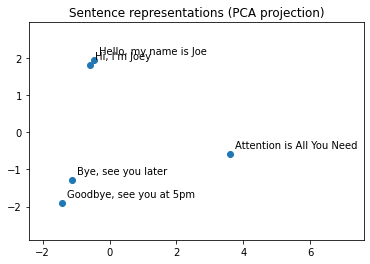

In [ ]:
#@title  { run: "auto", vertical-output: true }

#@markdown Show 5 DistilBERT sentence representations to 2-D
sentence_1 = "Hello, my name is Joe" #@param {type:"string"}
sentence_2 = "Hi, I'm Joey" #@param {type:"string"}
sentence_3 = "Goodbye, see you at 5pm" #@param {type:"string"}
sentence_4 = "Bye, see you later" #@param {type:"string"}
sentence_5 = "Attention is All You Need" #@param {type:"string"}


sentences = [sentence_1, sentence_2, sentence_3, sentence_4, sentence_5]

distilbert_output, sentence_repr = get_sents_representations(sentences)

print(f"DistilBERT output: {distilbert_output.shape}")
print(f"Sentence representations: {sentence_repr.shape}")
print("\n")

pca = PCA(n_components=2)
sentence_repr_2d = pca.fit_transform(sentence_repr.detach().numpy())

fig, ax = plt.subplots()
plt.scatter(sentence_repr_2d[:,0], sentence_repr_2d[:,1])
plt.title("Sentence representations (PCA projection)")
plt.xlim(sentence_repr_2d[:,0].min() - 1, sentence_repr_2d[:,0].max() + 4)
plt.ylim(sentence_repr_2d[:,1].min() - 1, sentence_repr_2d[:,1].max() + 1)

for x, y, s in zip(sentence_repr_2d[:,0], sentence_repr_2d[:,1], sentences):
    plt.text(x+0.15, y+0.15, s)

plt.show()

## TinyGAN
In the following example, you can experiment with a computer-vision related application: GANS.

one of the most famous aplications of distillation: DistilBERT. In this [paper](https://arxiv.org/abs/1910.01108) they proved that they could use a smaller version of the model with fewer parameters and less computational resources.

For comparison:

*   BigGAN had 50.1 million parameters for the Generator, that performed 8.32 flops.
*   TinyGAN had 3.1 million parameters for the Generator, that performed 0.44 flops.


That is, using a model that is 16 times smaller without loosing performance.

In [ ]:
!git clone https://github.com/terarachang/ACCV_TinyGAN

Cloning into 'ACCV_TinyGAN'...
remote: Enumerating objects: 77, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 77 (delta 5), reused 0 (delta 0), pack-reused 63
Unpacking objects: 100% (77/77), done.
Checking out files: 100% (29/29), done.


In [ ]:
cd ACCV_TinyGAN

/content/ACCV_TinyGAN


In [ ]:
import torch
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
from model import Generator
from utils import *
G = Generator(image_size=128, conv_dim=32, z_dim=128, c_dim=128, repeat_num=5)
restore_model(30, 'gan/models', G, None, None, None)
G.to(device)
G.eval()

The trained models from gan/models/model_30.tar are loaded !


Generator(
  (embeding): Embedding(1000, 128)
  (fc): Linear(in_features=128, out_features=8192, bias=True)
  (blocks): Sequential(
    (0): GBlock(
      (dw_conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=512)
      (dw_conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=512)
      (pw_conv1): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (pw_conv2): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (c_sc): Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1))
      (cbn0): CBN2d(
        (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        (embed): Linear(in_features=128, out_features=1024, bias=True)
      )
      (cbn1): CBN2d(
        (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
        (embed): Linear(in_features=128, out_features=1024, bias=True)
      )
    )
    (1): GBlock(
      (dw_conv1): Conv2d(512, 512,

Run this two cells as many times as you would like, to see different results.

In [ ]:
z_dim = 128
n_row = 5
n_samples = n_row * n_row
noise = torch.FloatTensor(truncated_normal(n_samples*z_dim)) \
										.view(n_samples, z_dim).to(device)

label = np.random.choice(398, n_row, replace=False) # sample from all animal classes
print(label)
label_t = torch.tensor(label).repeat(n_row).to(device)

#get the 5 predictions prediction conditioned to the label for 5 samples
with torch.no_grad():
  out = G(noise, label_t).detach().cpu()

[392 333 326 320 167]


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


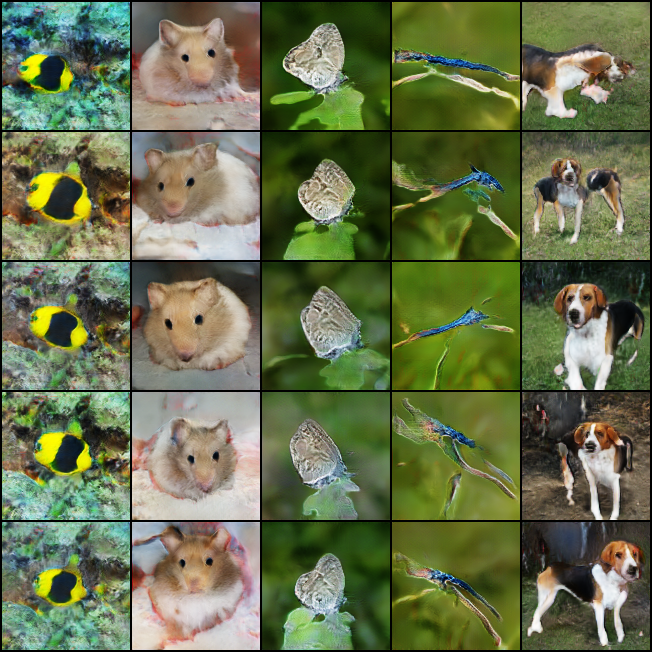

In [ ]:
from torchvision.utils import save_image
from IPython.display import Image
save_image(denorm(out), 'demo.png', nrow=n_row)
Image(filename='demo.png')